In [1]:
# IMPORTS

import os
import json
import datetime
from collections import defaultdict
import re, string, unicodedata
import nltk
import statistics
from nltk.util import ngrams
from nltk import sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import itertools
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import words
from collections import Counter
import operator
import pprint
import datetime
import matplotlib.dates as mdates

In [2]:
# HELPER FUNCTIONS

def notin(target, comparelist):
    for element in comparelist:
        if element in target:
            return False
    return True

def preprocess(words):
    words = words.lower()
    # weird thing with apostrophe showing up as this unicode string
    words = re.sub("\u00e2\u0080\u0099", "'", words)
    # filter out all remaining Unicode, TODO: maybe want to translate these into emojis?
    words = words.encode("ascii", "ignore").decode("UTF-8")
    return words

def print_sorted_dict(d, first_x=None):
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for i, key in enumerate(sorted_keys):
        if first_x is not None and i >= first_x:
            break
        print(f"Rank {i+1}:", key, d[key])
    return sorted_keys

def is_contraction(word):
    if "'" in word:
        split_word = word.split("'")
        if len(split_word) > 1 and split_word[0] in english_words:
            return True
    return False

def exclude_word(word):
    return (len(word) < 1 or word in english_words or word.isdigit() 
            or is_contraction(word) or word in standard_contractions)

pp = pprint.PrettyPrinter(indent=4)
def print_term_to_senders():
    pp.pprint(term_to_senders)

In [3]:
standard_contractions = set(["aren't", "can't", "could've", "couldn't", "didn't", 
                "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", 
                "how'd", "how'll", "how's", "i'd", "i'll", "i'm", "i've", "isn't", "it'd", 
                "it'll", "it's", "let's", "might've", "mightn't", "must've", 
                "mustn't", "needn't", "o'clock", "she'd", "she'll", "she's", 
                "should've", "shouldn't", "so's", "that'd", "that's", "there'd", 
                "there's", "they'd", "they'll", "they're", "they've", "wasn't", 
                "we'd", "we'll", "we're", "we've", "weren't", "what'll", "what're", "what's",
                "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", 
                "who's", "who've", "why's", "won't", "would've", 
                "wouldn't", "you'd", "you'll", "you're", "you've"])

In [4]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# sample use cases
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

# 2. Lemmatize Single Word with the appropriate POS tag
# word = 'feet'
# print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

# 3. Lemmatize a Sentence with the appropriate POS tag
# sentence = "The striped bats are hanging on their feet for best"
# print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

Rank 1: George Zhang 25551
Rank 2: Ooga Nam 17177
Rank 3: Claire Haupt 15374
Rank 4: Steve Kim 14150
Rank 5: Gloria Durley 7421
Rank 6: Allyson Margaret 6611
Rank 7: Noah Simon 4359
Rank 8: Tal Modiano 4115
Rank 9: Harika Lingareddy 3679
Rank 10: Lea Silvert 2984
Rank 11: David Cease 2917
Rank 12: Katie Meehan 2678
Rank 13: Daniel Bellin 2407
Rank 14: Daniel Chen 2404
Rank 15: Joey Levin 2280
Rank 16: Kimberly Liang 1510
Rank 17: Barak Davidi 1388
Rank 18: Ethan Bershtein 1346
Rank 19: Diana Kate Karsanow 1269
Rank 20: Aaron Zhang 1236
Rank 21: Samantha Adzigian 1199
Rank 22: Matthew Arovas 1179
Rank 23: Kathleen Tajmajer 1179
Rank 24: Krystal Sarcone 1099
Rank 25: Matt Gad 1074
Rank 26: Emy Han 990
Rank 27: Nadav Battat 973
Rank 28: Maximillian Karsanow 897
Rank 29: Ruth Chartoff 847
Rank 30: Alexa Babbitt 591
Rank 31: Jack Roswell 572
Rank 32: Arvene Golbazi 533
Rank 33: Leah Bradleigh 505
Rank 34: Leo Penny 501
Rank 35: Aleya Laiken 497
Rank 36: Claire Tiefenthaler 495
Rank 37: Mack

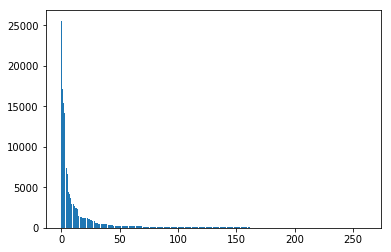

In [6]:
# extract message dictionaries

msg_dir = "/Users/eli/Desktop/reestablish the power app/Facebook/facebook-elisilvert/messages/inbox"
account_user_name = "Eli Silvert"

# list of message dictionaries of interest
conv_dicts = {}
friend_to_num_msgs = defaultdict(lambda: 0)

for dir_name in os.listdir(msg_dir):
    if not dir_name.startswith("."):
        file_path = os.path.join(msg_dir, dir_name, 'message_1.json')
        
        # make sure file exists
        if os.path.exists(file_path):
            json_dict = json.load(open(file_path, 'r'))

            # only look at DM's with more than 10 messages
            if len(json_dict['participants']) == 2 and len(json_dict['messages']) > 10:
                for friend_dict in json_dict['participants']:
                    friend_name = friend_dict["name"]
                    if friend_name != account_user_name:
                        num_msgs = len(json_dict['messages'])
                        friend_to_num_msgs[friend_name] = num_msgs

# print counts
sorted_names = print_sorted_dict(friend_to_num_msgs)

plt.bar(list(range(len(sorted_names))), [friend_to_num_msgs[name] for name in sorted_names])
    
# top ten percentile of friends        
top_ten_percentile = sorted_names[:len(sorted_names) // 10]

for dir_name in os.listdir(msg_dir):
    if not dir_name.startswith("."):
        file_path = os.path.join(msg_dir, dir_name, 'message_1.json')
        
        # make sure file exists
        if os.path.exists(file_path):
            json_dict = json.load(open(file_path, 'r'))

            # only look at DM's with more than 10 messages
            if len(json_dict['participants']) == 2 and len(json_dict['messages']) > 10:
                for friend_dict in json_dict['participants']:
                    friend_name = friend_dict["name"]
                    if friend_name != account_user_name and friend_name in top_ten_percentile:
                        print(friend_name)
                        conv_dicts[friend_name] = json_dict

In [7]:
# counts number of words

friend_to_words = defaultdict(lambda: 0)

for friend_name, conv_dict in conv_dicts.items():
    print("Friend name:", friend_name)
    print("=" * 50)
    
    messages = conv_dict["messages"]
    for (index, msg) in enumerate(messages):
        try:
            content = msg['content']
            tok_content = content.split()
            friend_to_words[friend_name] += len(tok_content)
        except KeyError:
            pass
_ = print_sorted_dict(friend_to_words, first_x=25)

Friend name: Tal Modiano
Friend name: Allyson Margaret
Friend name: Aaron Zhang
Friend name: Harika Lingareddy
Friend name: Diana Kate Karsanow
Friend name: Katie Meehan
Friend name: Samantha Adzigian
Friend name: Krystal Sarcone
Friend name: Matthew Arovas
Friend name: Claire Haupt
Friend name: Ethan Bershtein
Friend name: Emy Han
Friend name: George Zhang
Friend name: Ooga Nam
Friend name: Gloria Durley
Friend name: Kathleen Tajmajer
Friend name: Steve Kim
Friend name: David Cease
Friend name: Matt Gad
Friend name: Daniel Chen
Friend name: Lea Silvert
Friend name: Joey Levin
Friend name: Noah Simon
Friend name: Kimberly Liang
Friend name: Barak Davidi
Friend name: Daniel Bellin
Rank 1: George Zhang 124928
Rank 2: Ooga Nam 112297
Rank 3: Claire Haupt 103171
Rank 4: Steve Kim 79840
Rank 5: Gloria Durley 35513
Rank 6: Allyson Margaret 34979
Rank 7: Tal Modiano 25478
Rank 8: Katie Meehan 22876
Rank 9: Harika Lingareddy 22214
Rank 10: Noah Simon 19101
Rank 11: Diana Kate Karsanow 15990
Ra

In [8]:
#  get monogram/bigram/trigrams

from nltk.corpus import words

english_words = set(words.words())

term_to_senders = {}
# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

def add_term_timestamp(term_dict, term, friend_name, sender_name, timestamp_ms):
    # figure out which person didn't send it
    non_sender = friend_name
    if friend_name == sender_name:
        non_sender = account_user_name
    
    # term doesn't exist in dict
    if term_dict.get(term) is None:
        term_dict[term] = {
            friend_name: {
                sender_name: [timestamp_ms],
                non_sender: []
            }
        }
    else: # term exists in dict
        if term_dict[term].get(friend_name) is None: # not yet found in this conversation
            term_dict[term][friend_name] = { sender_name: [timestamp_ms], non_sender: [] }
        else:
            term_dict[term][friend_name][sender_name].append(timestamp_ms)

for friend_name, conv_dict in conv_dicts.items():
    print("Conversation with", friend_name)
    print("=" * 50)

    messages = conv_dict["messages"]
    for (index, msg) in enumerate(messages): 
        try:
            sender_name = msg["sender_name"]
            content = msg["content"]
            timestamp_ms = msg["timestamp_ms"]

            if notin(content, ["You are now connected on Messenger.", "Say hi to your new Facebook friend"]):
                content = preprocess(content)
                
#                 alternate ways of tokenizing
#                 tok_content = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(content)]
#                 tok_content = nltk.word_tokenize(content)

                tok_content = content.split()

                # monograms
                for word in tok_content:
                    word = word.strip(string.punctuation)
                    if len(word) > 0:
                        word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                        if not exclude_word(word):
                            add_term_timestamp(term_to_senders, word, friend_name, sender_name, timestamp_ms)
                        
                # bigrams
                for (tok1, tok2) in ngrams(tok_content, 2):
                    tok1 = tok1.strip(string.punctuation)
                    tok2 = tok2.strip(string.punctuation)
                    if (exclude_word(tok1) and exclude_word(tok2)
                        or (tok1.isdigit() or tok2.isdigit())):
                        continue
                    else:
                        add_term_timestamp(term_to_senders, (tok1, tok2), friend_name, sender_name, timestamp_ms)
                        
                # trigrams
                for (tok1, tok2, tok3) in ngrams(tok_content, 3):
                    tok1 = tok1.strip(string.punctuation)
                    tok2 = tok2.strip(string.punctuation)
                    tok3 = tok3.strip(string.punctuation)
                    num_stop = 0
                    if exclude_word(tok1):
                        num_stop += 1
                    if exclude_word(tok2):
                        num_stop += 1
                    if exclude_word(tok3):
                        num_stop += 1
                        
                    if num_stop >= 2:
                        continue
                    else:
                        add_term_timestamp(term_to_senders, (tok1, tok2, tok3), friend_name, sender_name, timestamp_ms)
        except KeyError:
            # messages that are just photos don't have a content key
            pass

Conversation with Tal Modiano
Conversation with Allyson Margaret
Conversation with Aaron Zhang
Conversation with Harika Lingareddy
Conversation with Diana Kate Karsanow
Conversation with Katie Meehan
Conversation with Samantha Adzigian
Conversation with Krystal Sarcone
Conversation with Matthew Arovas
Conversation with Claire Haupt
Conversation with Ethan Bershtein
Conversation with Emy Han
Conversation with George Zhang
Conversation with Ooga Nam
Conversation with Gloria Durley
Conversation with Kathleen Tajmajer
Conversation with Steve Kim
Conversation with David Cease
Conversation with Matt Gad
Conversation with Daniel Chen
Conversation with Lea Silvert
Conversation with Joey Levin
Conversation with Noah Simon
Conversation with Kimberly Liang
Conversation with Barak Davidi
Conversation with Daniel Bellin


In [10]:
import copy
term_to_senders_original = copy.deepcopy(term_to_senders)
# print(len(term_to_senders))
# print(len(term_to_senders_original))

In [11]:
# FILTER term_to_senders, 
# TODO: sort by occurrernce, and see the cutoff filtering based on something besides frequency

# term_to_senders schema
# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

term_to_senders = copy.deepcopy(term_to_senders_original)
terms_to_delete = []
term_to_count = defaultdict(lambda: 0)
for term in term_to_senders:
    num_usages = 0
    for friend_name in term_to_senders[term]:
        for user_name in term_to_senders[term][friend_name]:
            num_usages += len(term_to_senders[term][friend_name][user_name])
    if num_usages < 4:
        terms_to_delete.append(term)
    else:
        term_to_count[term] += num_usages
for term in terms_to_delete:
     del term_to_senders[term]
print(len(term_to_senders)) # should be 10465

9933


In [12]:
# PRINTS SLANG RANKED BY USAGE, ACROSS ALL USERS
_ = print_sorted_dict(term_to_count)

Rank 1: lol 8135
Rank 2: gloria 7797
Rank 3: whatd 7627
Rank 4: ('gloria', 'say') 7441
Rank 5: ('whatd', 'gloria') 7438
Rank 6: ('whatd', 'gloria', 'say') 7437
Rank 7: ('say', 'whatd') 7424
Rank 8: ('gloria', 'say', 'whatd') 7424
Rank 9: ('say', 'whatd', 'gloria') 7424
Rank 10: haha 7106
Rank 11: im 4208
Rank 12: lal 2535
Rank 13: gonna 2248
Rank 14: idk 2080
Rank 15: ok 1995
Rank 16: fuck 1800
Rank 17: shit 1745
Rank 18: cuz 1576
Rank 19: wanna 1490
Rank 20: bro 1315
Rank 21: hahaha 1241
Rank 22: eli 952
Rank 23: hahah 887
Rank 24: ik 808
Rank 25: dat 735
Rank 26: gotta 705
Rank 27: kinda 638
Rank 28: nah 604
Rank 29: ('im', 'not') 600
Rank 30: okay 547
Rank 31: idkk 505
Rank 32: okk 439
Rank 33: bruh 436
Rank 34: ppl 434
Rank 35: noo 427
Rank 36: bb 417
Rank 37: ('lol', 'i') 410
Rank 38: soo 400
Rank 39: ('haha', 'i') 399
Rank 40: ('gonna', 'be') 393
Rank 41: shes 392
Rank 42: mom 383
Rank 43: ('im', 'gonna') 381
Rank 44: yeee 359
Rank 45: nooo 351
Rank 46: email 345
Rank 47: claire 

Rank 988: homie 29
Rank 989: ("you're", 'gonna') 29
Rank 990: worksheet 29
Rank 991: srp 29
Rank 992: nicole 29
Rank 993: mc 29
Rank 994: gpa 29
Rank 995: ofc 29
Rank 996: ('or', 'nah') 28
Rank 997: ('lol', 'just') 28
Rank 998: ('were', 'gonna') 28
Rank 999: ('english', 'essay') 28
Rank 1000: idrk 28
Rank 1001: dammit 28
Rank 1002: hhaha 28
Rank 1003: nevermind 28
Rank 1004: ook 28
Rank 1005: ('hes', 'like') 28
Rank 1006: ('n', 'shit') 28
Rank 1007: ('i', 'g2gg') 28
Rank 1008: ('gonna', 'b') 28
Rank 1009: ('cuz', 'like') 28
Rank 1010: ('im', 'on') 28
Rank 1011: claires 28
Rank 1012: ('and', 'idkk') 28
Rank 1013: tellin 28
Rank 1014: uhhhh 28
Rank 1015: doooo 28
Rank 1016: ('it', 'cuz') 28
Rank 1017: ('lol', 'jk') 28
Rank 1018: smd 28
Rank 1019: ('so', 'fucking') 28
Rank 1020: ('for', 'chem') 28
Rank 1021: ('sci', 'res') 28
Rank 1022: ('i', 'gtg') 28
Rank 1023: dumbass 28
Rank 1024: ('and', 'nooo') 28
Rank 1025: ('your', 'parents') 28
Rank 1026: thaats 28
Rank 1027: ('bruh', 'i') 27
Ran

Rank 1872: ('ik', 'ikk') 16
Rank 1873: chen 16
Rank 1874: funnyy 16
Rank 1875: ('haha', 'just') 16
Rank 1876: fri 16
Rank 1877: ('lal', 'thats') 16
Rank 1878: ('fuck', 'no') 16
Rank 1879: 2morrow 16
Rank 1880: fucker 16
Rank 1881: ('he', 'likes') 16
Rank 1882: ('might', 'wanna') 16
Rank 1883: bruhhhh 16
Rank 1884: shtuff 16
Rank 1885: ('nah', 'im') 16
Rank 1886: ('lol', 'same') 16
Rank 1887: hardest 16
Rank 1888: backpack 16
Rank 1889: explains 16
Rank 1890: ('gonna', 'suck') 16
Rank 1891: looool 16
Rank 1892: hereee 16
Rank 1893: ('yeah', 'ikk') 16
Rank 1894: ('school', 'tmrw') 16
Rank 1895: nacl 16
Rank 1896: ('to', 'mr') 16
Rank 1897: mol 16
Rank 1898: hmmmmm 16
Rank 1899: xc 16
Rank 1900: regan 16
Rank 1901: diana 16
Rank 1902: ('lol', 'okaay') 16
Rank 1903: ooohh 16
Rank 1904: ('was', 'ok') 16
Rank 1905: ('why', 'wld') 16
Rank 1906: ('and', 'ahh') 16
Rank 1907: ('few', 'weeks') 16
Rank 1908: ('ahh', "i'm") 16
Rank 1909: ('haha', 'okayy') 16
Rank 1910: ('with', 'mee') 16
Rank 1911:

Rank 3048: idrc 10
Rank 3049: ('bad', 'lol') 10
Rank 3050: ('just', 'kidding') 10
Rank 3051: ('im', 'excited') 10
Rank 3052: ('wanna', 'write') 10
Rank 3053: ('itll', 'probably') 10
Rank 3054: ('think', 'youre') 10
Rank 3055: ('youre', 'right') 10
Rank 3056: ('ahhh', 'i') 10
Rank 3057: ('nah', 'it') 10
Rank 3058: toooooo 10
Rank 3059: ('yeah', 'haha') 10
Rank 3060: sweg 10
Rank 3061: ('the', 'ap') 10
Rank 3062: ('good', 'grades') 10
Rank 3063: ('ok', 'eli') 10
Rank 3064: ('i', 'hve') 10
Rank 3065: kate 10
Rank 3066: ('but', 'ahh') 10
Rank 3067: ('hahaha', 'nooo') 10
Rank 3068: wellllll 10
Rank 3069: ("it's", 'okay') 10
Rank 3070: ('wanna', 'give') 10
Rank 3071: ('pissed', 'off') 10
Rank 3072: ('u', 'toooo') 10
Rank 3073: ('lol', 'oo') 10
Rank 3074: ('mom', 'would') 10
Rank 3075: realllly 10
Rank 3076: ('wanna', 'put') 10
Rank 3077: youuuuu 10
Rank 3078: ('nooo', "i'm") 10
Rank 3079: ('hahaha', 'oh') 10
Rank 3080: okkkay 10
Rank 3081: ('convo', 'with') 10
Rank 3082: ('just', 'walked') 1

Rank 3947: ('ud', 'be') 8
Rank 3948: ('mackenzie', 'and') 8
Rank 3949: ('idk', 'yet') 8
Rank 3950: ('haha', 'shit') 8
Rank 3951: ('yeahh', 'it') 8
Rank 3952: hashtag 8
Rank 3953: ('says', 'its') 8
Rank 3954: ('tell', 'uuu') 8
Rank 3955: ('gives', 'a', 'fuck') 8
Rank 3956: ('dunno', 'if') 8
Rank 3957: afff 8
Rank 3958: ("doesn't", 'wanna') 8
Rank 3959: ('okay', 'with') 8
Rank 3960: ('like', 'having') 8
Rank 3961: oohhh 8
Rank 3962: ('think', 'thatll') 8
Rank 3963: ('thank', 'youuu') 8
Rank 3964: ('haha', 'niceeee') 8
Rank 3965: ('ideas', 'for') 8
Rank 3966: ('idk', 'which') 8
Rank 3967: bett 8
Rank 3968: ('uh', 'ohhh') 8
Rank 3969: ('lal', 'yah') 8
Rank 3970: mama 8
Rank 3971: disney 8
Rank 3972: ('happens', 'when') 8
Rank 3973: clicked 8
Rank 3974: ('ok', 'this') 8
Rank 3975: reminds 8
Rank 3976: ('reminds', 'me') 8
Rank 3977: ('wanna', 'work') 8
Rank 3978: decides 8
Rank 3979: ('kinda', 'late') 8
Rank 3980: 1.5 8
Rank 3981: ('called', 'the') 8
Rank 3982: goggles 8
Rank 3983: ('thing',

Rank 5005: heheh 6
Rank 5006: ('me', 'tht') 6
Rank 5007: fagg 6
Rank 5008: ('hahaha', 'thanks') 6
Rank 5009: ('just', 'dnt') 6
Rank 5010: ('cares', 'if') 6
Rank 5011: ('ppl', 'and') 6
Rank 5012: ('mee', 'lal') 6
Rank 5013: ('do', 'anythingg') 6
Rank 5014: ('ooo', 'thats') 6
Rank 5015: fromm 6
Rank 5016: ('haha', 'does') 6
Rank 5017: ('is', 'claire') 6
Rank 5018: ('so', 'cutee') 6
Rank 5019: ('those', 'ppl') 6
Rank 5020: wna 6
Rank 5021: ('ppl', 'there') 6
Rank 5022: ('ikkk', 'but') 6
Rank 5023: annoyin 6
Rank 5024: ('claire', 'to') 6
Rank 5025: ('about', 'thatt') 6
Rank 5026: shldd 6
Rank 5027: campp 6
Rank 5028: ('i', 'wanna', 'fuck') 6
Rank 5029: ('wanna', 'fuck', 'u') 6
Rank 5030: ('mehh', 'i') 6
Rank 5031: ('aww', 'im') 6
Rank 5032: ('lal', 'hbuu') 6
Rank 5033: ('im', 'fuckin') 6
Rank 5034: ('i', 'dnt', 'wanna') 6
Rank 5035: ('hahah', 'okk') 6
Rank 5036: ('doo', 'itt') 6
Rank 5037: ('i', 'wana') 6
Rank 5038: ('wanna', 'but') 6
Rank 5039: relationshipp 6
Rank 5040: ('you', 'wantt') 

Rank 6124: muchhhh 5
Rank 6125: ('and', 'imm') 5
Rank 6126: ('idk', 'and') 5
Rank 6127: ('wit', 'shauna') 5
Rank 6128: ('of', 'youu') 5
Rank 6129: drivin 5
Rank 6130: ('lal', 'sorry') 5
Rank 6131: ('willl', 'and') 5
Rank 6132: ('take', 'urs') 5
Rank 6133: ('haha', 'of') 5
Rank 6134: ('backk', 'and') 5
Rank 6135: ('like', 'kathleen') 5
Rank 6136: ('and', 'naaah') 5
Rank 6137: ('so', 'muchh') 5
Rank 6138: ('thats', 'sadd') 5
Rank 6139: ('friends', 'now') 5
Rank 6140: ('claire', 'said') 5
Rank 6141: ('believed', 'it') 5
Rank 6142: nuttinn 5
Rank 6143: easyy 5
Rank 6144: ('tell', 'allyson') 5
Rank 6145: ('im', 'gonna', 'send') 5
Rank 6146: ('shldnt', 'have') 5
Rank 6147: drunkk 5
Rank 6148: ('haha', 'then') 5
Rank 6149: mabadd 5
Rank 6150: ('its', 'nottt') 5
Rank 6151: ('dat', 'shitt') 5
Rank 6152: ('idkk', 'bout') 5
Rank 6153: bangin 5
Rank 6154: hottest 5
Rank 6155: ('yess', 'haha') 5
Rank 6156: ('lal', 'naaah') 5
Rank 6157: ('he', 'iss') 5
Rank 6158: ('we', 'aree') 5
Rank 6159: datd 5
R

Rank 7074: ('other', 'places') 5
Rank 7075: cheaper 5
Rank 7076: ('oh', 'sheit') 5
Rank 7077: ('lol', "we're") 5
Rank 7078: ('email', 'josh') 5
Rank 7079: ('ap', 'tests') 5
Rank 7080: doooooood 5
Rank 7081: ('bruh', "it's") 5
Rank 7082: ('lol', 'idk', 'about') 5
Rank 7083: duuuuude 5
Rank 7084: ('you', 'shouldve') 5
Rank 7085: ('washu', 'is') 5
Rank 7086: ('shows', 'that') 5
Rank 7087: stg 5
Rank 7088: erps 5
Rank 7089: ('different', 'places') 5
Rank 7090: ('thanks', 'beeb') 5
Rank 7091: ('sperry', 'falls') 5
Rank 7092: uploaded 5
Rank 7093: ('names', 'of') 5
Rank 7094: ('email', 'and') 5
Rank 7095: ('we', 'def') 5
Rank 7096: schiz 5
Rank 7097: ('pics', 'are') 5
Rank 7098: ('oh', 'dayum') 5
Rank 7099: ('those', 'figures') 5
Rank 7100: ('gotta', 'put') 5
Rank 7101: hears 5
Rank 7102: ('im', 'missing') 5
Rank 7103: ('bruh', 'its') 5
Rank 7104: ('bro', 'its') 5
Rank 7105: ('ight', 'so') 5
Rank 7106: ('gonna', 'visit') 5
Rank 7107: ('kinda', 'forget') 5
Rank 7108: ('a', 'username') 5
Rank 

Rank 8081: outsidee 4
Rank 8082: minden 4
Rank 8083: ('boutta', 'go') 4
Rank 8084: ('ok', 'ima') 4
Rank 8085: ('oh', 'gotcha') 4
Rank 8086: wyd 4
Rank 8087: boiiiiiiii 4
Rank 8088: venmo 4
Rank 8089: ('tomorrow', 'ev') 4
Rank 8090: ('doin', 'some') 4
Rank 8091: ('howd', 'it') 4
Rank 8092: ('hahaha', 'damn') 4
Rank 8093: ('lol', 'should') 4
Rank 8094: ('good', 'convo') 4
Rank 8095: flappy 4
Rank 8096: ('flappy', 'bird') 4
Rank 8097: ('oh', 'rly') 4
Rank 8098: ('closes', 'at') 4
Rank 8099: ('chem', 'midterm') 4
Rank 8100: ('im', 'boutta') 4
Rank 8101: ('girl', 'named') 4
Rank 8102: ('yooo', 'bro') 4
Rank 8103: ('tryna', 'find') 4
Rank 8104: ('for', 'thursday') 4
Rank 8105: ('i', 'skipped') 4
Rank 8106: ('wanna', 'email') 4
Rank 8107: ('studying', 'spanish') 4
Rank 8108: ('calc', 'problem') 4
Rank 8109: 4-3 4
Rank 8110: ('pls', 'help') 4
Rank 8111: ('looks', 'kinda') 4
Rank 8112: ('my', 'backpack') 4
Rank 8113: ('ughh', 'i') 4
Rank 8114: ('chem', 'tomorrow') 4
Rank 8115: ('fucking', 'bet'

Rank 9116: ('parents', 'think') 4
Rank 9117: ('hah', 'okaay') 4
Rank 9118: ('social', 'studiess') 4
Rank 9119: ('april', 'fools') 4
Rank 9120: ('haha', 'im', 'sorry') 4
Rank 9121: minn 4
Rank 9122: ('lal', 'cooo') 4
Rank 9123: ('shes', 'really') 4
Rank 9124: spanishhh 4
Rank 9125: gayyyy 4
Rank 9126: ('ya', 'idk') 4
Rank 9127: mayyy 4
Rank 9128: ('fucking', 'awesome') 4
Rank 9129: ikk...lal 4
Rank 9130: ('which', 'isnt') 4
Rank 9131: ('ummm', 'its') 4
Rank 9132: ('de', 'fukkk') 4
Rank 9133: ('gloria', 'says') 4
Rank 9134: ('okay', 'to') 4
Rank 9135: donttttt 4
Rank 9136: ('yee', 'dats') 4
Rank 9137: bitcch 4
Rank 9138: ('datd', 'be') 4
Rank 9139: ('hes', 'never') 4
Rank 9140: ('', 'lal') 4
Rank 9141: ftwwww 4
Rank 9142: ('gonna', 'shoot') 4
Rank 9143: ('haha', 'ok', 'well') 4
Rank 9144: ('ppl', 'dont') 4
Rank 9145: ('happened', 'like') 4
Rank 9146: ('wutch', 'u') 4
Rank 9147: braaahhh 4
Rank 9148: ('eli', 'to') 4
Rank 9149: ('guys', 'will') 4
Rank 9150: ('it', 'upppp') 4
Rank 9151: ('h

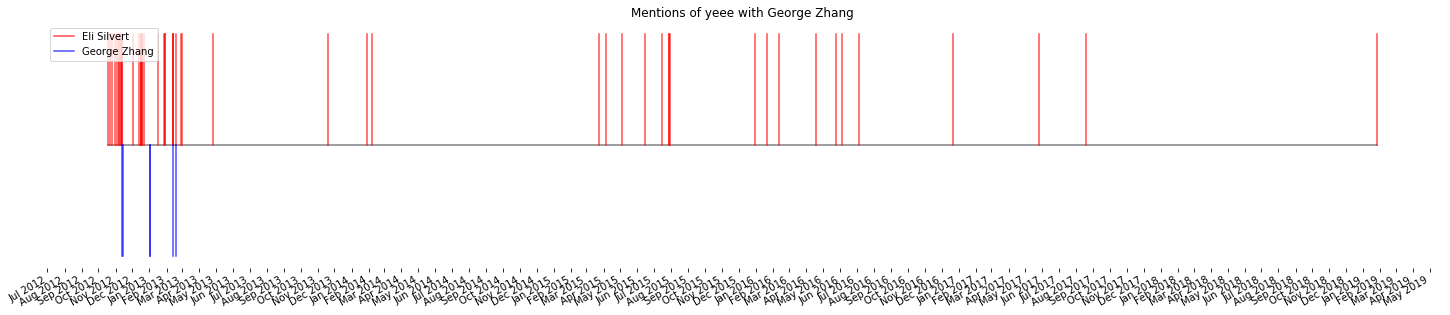

In [18]:
# MODIFY THESE
# =================================
term_examined = "yeee"
friend_name = "George Zhang"
account_user_name = "Eli Silvert"
# =================================
sample_dict = term_to_senders[term_examined][friend_name]

other_mentions = [datetime.datetime.utcfromtimestamp(i / 1000).replace(tzinfo=datetime.timezone.utc) for i in sample_dict[friend_name]]
me_mentions = [datetime.datetime.utcfromtimestamp(i / 1000).replace(tzinfo=datetime.timezone.utc) for i in sample_dict[account_user_name]]

# This tutorial as reference: https://matplotlib.org/3.0.0/gallery/lines_bars_and_markers/timeline.html

fig, ax = plt.subplots(figsize=(25, 5))

# Create the base line
start = min(me_mentions + other_mentions)
stop = max(me_mentions + other_mentions)
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

# Iterate through releases annotating each one
for i, date in enumerate(me_mentions):
    ax.plot((date, date), (0, 1), c='r', alpha=.7, label=f"{account_user_name}" if i == 0 else "_nolegend_")
for i, date in enumerate(other_mentions):
    # Plot a line up to the text
    ax.plot((date, date), (0, -1), c='b', alpha=.7, label=f"{friend_name}" if i == 0 else "_nolegend_")

ax.set(title=f"Mentions of {term_examined} with {friend_name}")
# Set the xticks formatting
# TODO: make the month interval calculation dynamic based on difference between start and stop
# format xaxis with x month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()

plt.legend(loc='upper left');

# Remove components for a cleaner look
plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)
plt.show()